In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import Ridge, Lasso

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from warnings import filterwarnings

filterwarnings('ignore')

%matplotlib inline

sns.set(style="darkgrid")
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

**Task 1**. We will be working with data from the [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview) competition, which was about predicting the duration of a taxi trip. Download the training sample from this competition and upload it:

In [32]:
!pip install -U -q pyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [33]:
#authenticate
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [34]:
#https://drive.google.com/file/d/1YMJjh5ATwE83xUFOduHBQooS_bI7r3kO/view?usp=sharing
train_downloaded = drive.CreateFile({'id':'1YMJjh5ATwE83xUFOduHBQooS_bI7r3kO'})
train_downloaded.GetContentFile('train.csv')


In [35]:
df_Ztrain = pd.read_csv('train.csv')

In [36]:
df_Ztrain.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


Pay attention to the `pickup_datetime` and `dropoff_datetime` columns. `dropoff_datetime` was added only to the training sample, so, this column cannot be used, let's delete it. `pickup_datetime` contains the date and time the trip started. To make it convenient to work with, let's convert dates to `datetime` objects

In [10]:
train = df_Ztrain.drop('dropoff_datetime', axis=1)
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)

target = 'trip_duration'

The `trip_duration` column contains the target value we want to predict. Let's look at the distribution of the target in the training sample. To do this, draw its histogram:

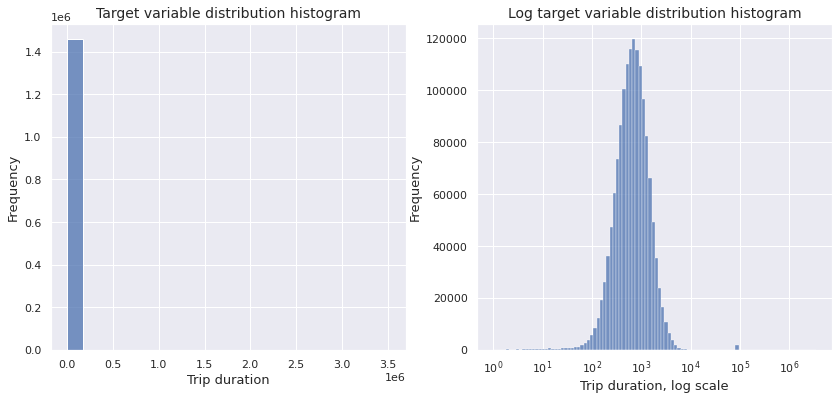

In [11]:
plt.rcParams["figure.figsize"] = (14,6)

fig, ax = plt.subplots(ncols=2)

sns.histplot(data=train, x=target, bins=20, ax=ax[0])
#plot similar histogram with parameter log_scale, choose informative amount of bins and correct axis
#your code here

sns.histplot(data=train, x=target, bins=100, ax=ax[1],log_scale = True)

#end of your code


ax[0].set_title('Target variable distribution histogram', dict(size=14))
ax[0].set_xlabel('Trip duration', dict(size=13))
ax[0].set_ylabel('Frequency', dict(size=13))

ax[1].set_title('Log target variable distribution histogram', dict(size=14))
ax[1].set_xlabel('Trip duration, log scale', dict(size=13))
_ = ax[1].set_ylabel('Frequency', dict(size=13))

**Question**: Why is it necessary to build a histogram in a logarithmic scale?

**Answer**

The competition used RMSLE as a quality metric:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Question**: Why do you think the contest authors chose RMSLE and not RMSE?

**Answer**

We have discussed several linear regression models in `sklearn`, but each of them optimized the mean square error (MSE), not RMSLE. Let's do the following trick: we will predict not the target variable, but its *logarithm*. Let $\hat{y}_i = \log{(y_i + 1)}$ be the modified target, and $\hat{a}(x_i)$ be the prediction of the model trained on $\hat{y}_i$, that is, the logarithm of the target. To predict the original value, we can simply take the exponent of our prediction: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

In addition, the logarithm of the target has another useful quality. To see it, add the `log_trip_duration` column to our sample (use `np.log1p`) and draw a histogram of the modified target for the training sample. Delete the column with the old target.

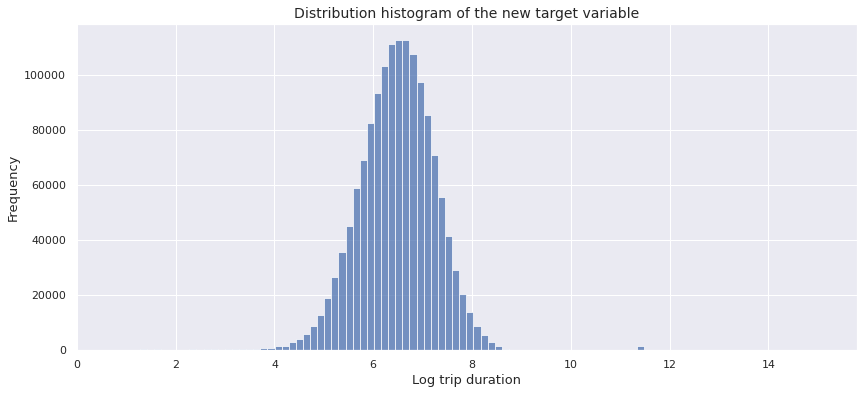

In [12]:
train['log_trip_duration'] = np.log1p(train[target])
#your code to delete target column from train is here:

train = train.drop(columns=['trip_duration'])

#end of your code
target = 'log_trip_duration'

plt.title('Distribution histogram of the new target variable', dict(size=14))
plt.xlabel('Log trip duration', dict(size=13))
plt.ylabel('Frequency', dict(size=13))
_ = sns.histplot(data=train, x=target, bins=100)

Let's calculate the value of the metric with the best constant prediction:

**Question**: why the best constant for RMSE is mean value?

**Answer**:

In [13]:
def RMSE(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean() ** .5

In [14]:
#your code to find constant prediction here:

const_model = train[target].mean()

#end of your code
print('Best constant prediction value: {}'.format(RMSE(train[target], const_model)))

Best constant prediction value: 0.7957592365411509


**Task 2**. First, let's see how many trips there were on each day. Plot the number of trips versus the day of the year:

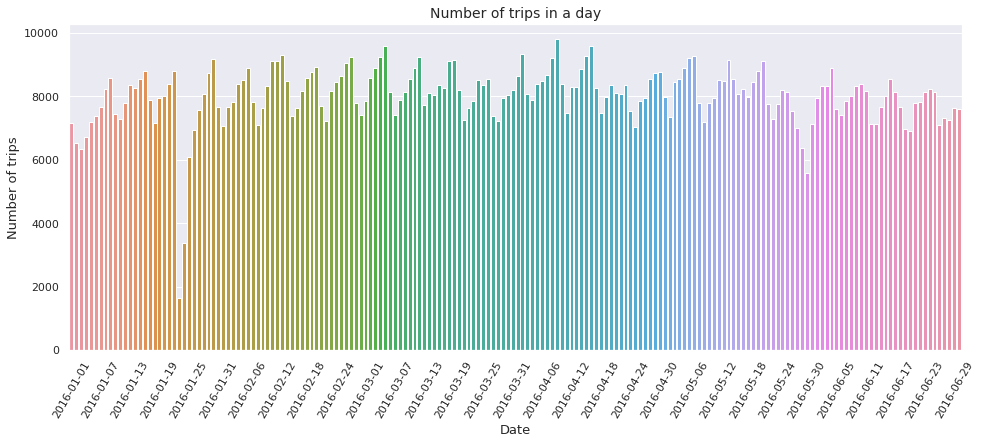

In [15]:
plt.rcParams["figure.figsize"] = (16,6)
train['day_of_year'] = train.pickup_datetime.dt.day_of_year

sns.countplot(x=train['day_of_year'])

plt.title('Number of trips in a day', dict(size=14))
plt.xlabel('Date', dict(size=13))
plt.ylabel('Number of trips', dict(size=13))

_ = plt.xticks(np.arange(0, 181, 6), np.unique(train.pickup_datetime.dt.date)[::6], rotation=60)

**Question**: You may have noticed that there are 2 periods on the graph with abnormally low numbers of trips. Calculate the dates on which these downward swings occurred and find information about what happened on those days in New York.

**Answer**:



Plot the number of trips versus the day of the week and the hours of the day (use `sns.relplot`):

In [16]:
train['hour'] = train.pickup_datetime.dt.hour
train['day_of_week'] = train.pickup_datetime.dt.day_of_week
train['day_of_year'] = train.pickup_datetime.dt.day_of_year
train['month_name'] = train.pickup_datetime.dt.month_name()

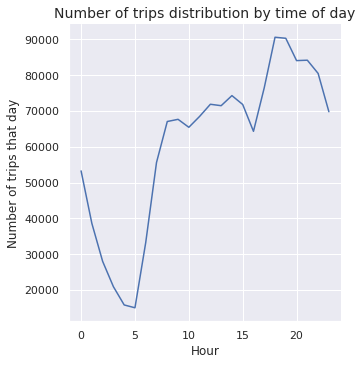

In [17]:
tmp_data = train.groupby('hour').id.count()\
.reset_index().rename({
    'hour': 'Hour',
    'id': 'Number of trips that day'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips that day',
            kind='line')
_ = plt.title('Number of trips distribution by time of day', dict(size=14))

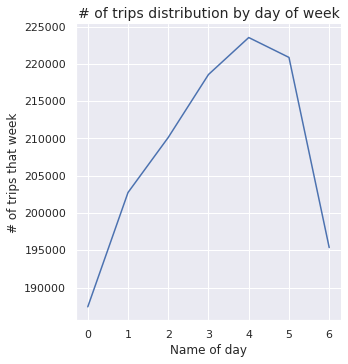

In [18]:
#your code for number of trips distribution by day of week

tmp_data = train.groupby('day_of_week').id.count()\
.reset_index().rename({
    'day_of_week': 'Name of day',
    'id': '# of trips that week'},
    axis=1
)
sns.relplot(data=tmp_data,
            x='Name of day',
            y='# of trips that week',
            kind='line')
_ = plt.title('# of trips distribution by day of week', dict(size=14))

#end of your code

**Task 3**. Draw on one graph the dependence of the number of trips on the hour of the day for different months (different curves corresponding to different months, color in different colors with use of `hue` in `sns.relplot`). Similarly, draw the dependence of the number of trips on the hour of the day for different days of the week.

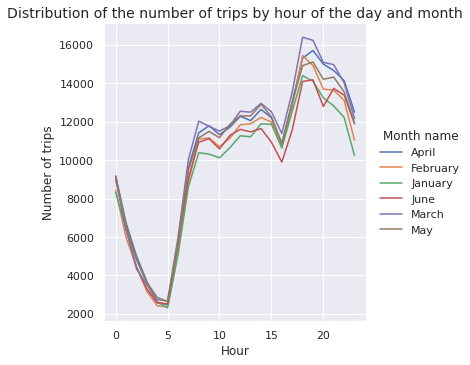

In [19]:
tmp_data = train.groupby(['month_name', 'hour']).id.count()\
.reset_index().rename({
    'month_name': 'Month name',
    'hour': 'Hour',
    'id': 'Number of trips'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips',
            hue='Month name',
            kind='line')
_ = plt.title('Distribution of the number of trips by hour of the day and month', dict(size=14))

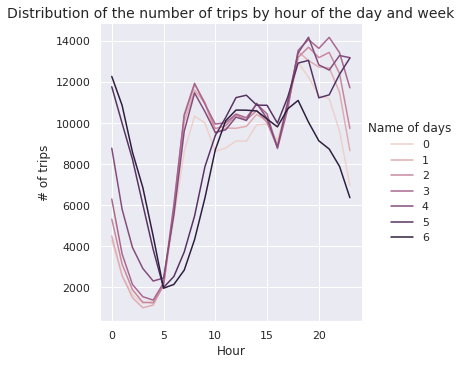

In [26]:
#your code for the dependence of the number of trips on the hour of the day for different days of the week is here:

tmp_data = train.groupby(['day_of_week', 'hour']).id.count()\
.reset_index().rename({
    'day_of_week': 'Name of days',
    'hour': 'Hour',
    'id': '# of trips'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='# of trips',
            hue='Name of days',
            kind='line'
            )
_ = plt.title('Distribution of the number of trips by hour of the day and week', dict(size=14))

#end of your code

**Question**: What conclusions can be drawn based on the graphs above? Are there any special days of the week? Months? Times of Day? What is it connected with?

**Answer**:

**Task 4**. Split the sample into train and test (7:3). For the train sample, plot the mean logarithm of travel time versus day of the week. Then do the same, but for the hour of the day and the day of the year.

Add the following traits based on `pickup_datetime`:
1. Day of the week
2. Month
3. Hour
4. Is the period anomalous (two binary signs corresponding to two anomalous periods)
5. Number of the day in the year

In [21]:
train = train.drop('month_name', axis=1)
train['month'] = train.pickup_datetime.dt.month

train['is_anomaly_jan'] = ((23 <= train.day_of_year) & (train.day_of_year <= 26)).astype('int')
train['is_anomaly_may'] = (train.day_of_year == 151).astype('int')

In [22]:
#your code for splitting is here:

train_data, test_data = train_test_split(train, test_size=0.7)

#end of ypur code

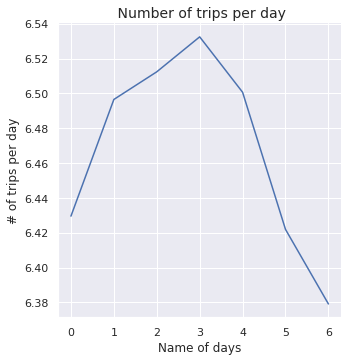

In [27]:
#your code for distribution of average trip duration by the number of day in a week is here:

tmp_data = train_data.groupby('day_of_week').log_trip_duration.mean()\
.reset_index().rename({
    'day_of_week': 'Name of days',
    'log_trip_duration': '# of trips per day'},
    axis=1)

sns.relplot(data=tmp_data,
            x='Name of days',
            y='# of trips per day',
            kind='line')
_ = plt.title(' Number of trips per day', dict(size=14))

#end of your code

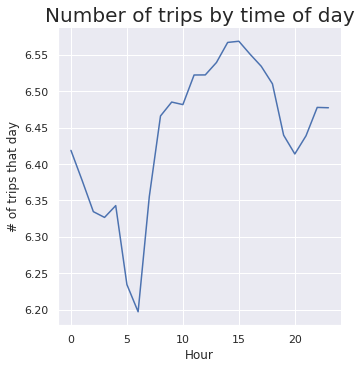

In [28]:
#your code for distribution of average trip duration by the hour of day is here:

tmp_data = train_data.groupby('hour').log_trip_duration.mean()\
.reset_index().rename({
    'hour': 'Hour',
    'log_trip_duration': '# of trips that day'},
    axis=1)

sns.relplot(data=tmp_data,
            x='Hour',
            y='# of trips that day',
            kind='line')
_ = plt.title('Number of trips by time of day', dict(size=20))


#end of your code

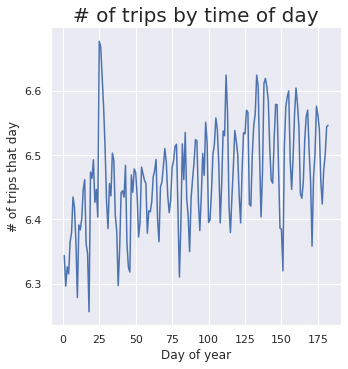

In [29]:
#your code for distribution of average trip duration by the number of day in the year is here:

tmp_data = train_data.groupby('day_of_year').log_trip_duration.mean()\
.reset_index().rename({
    'day_of_year': 'Day of year',
    'log_trip_duration': '# of trips that day'},
    axis=1)

sns.relplot(data=tmp_data,
            x='Day of year',
            y='# of trips that day',
            kind='line')
_ = plt.title('# of trips by time of day', dict(size=20))


#end of your code

**Question**: Are the graphs of the target depending on the day of the week and on the hour of the day similar to those for the number of trips? Why? What happens to the average target in those two anomalous periods that we saw above? Why is this happening? Do you see any trend in the plot of `log_trip_duration` versus day of the year?

**Answer**:

So, we have already created a number of features.

**Question**: Which of the features should be considered as categorical, and which - as numerical? Why?

**Answer**:

In [ ]:
train.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_year,hour,day_of_week,month,is_anomaly_jan,is_anomaly_may
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.96463,40.765602,N,6.122493,74,17,0,3,0,0


**Task 5**. Train `Ridge` regression with default parameters by encoding all categorical features with `OneHotEncoder`. Scale numerical features with `StandardScaler`. Use only the features that we have identified in this part of the task.

In [40]:
def make_pipeline(categorical, numeric, model):

  numeric_transformer = Pipeline(steps=[
      ('scaler', StandardScaler())
      ])
  #your code for categorical transformer is here:
  
  categorical_transformer = Pipeline(steps=[
      ('one_hot_encoder', OneHotEncoder(handle_unknown="ignore"))
      ])
  
  #end of ypur code

  preprocessor = ColumnTransformer(
      transformers=[
          ('numeric', numeric_transformer, numeric),
          ('categorical', categorical_transformer, categorical),
          ])
  pipeline = Pipeline(steps = [
      ('preprocessor', preprocessor),
      ('regressor', model)
      ])
  
  return pipeline    

def fit_pipeline(pipeline, train_data, test_data):
  #your code to is here:
  
  pipeline.fit(train_data, train_data['log_trip_duration'])
  
  #end of your code
  print('Train RMSE is {}'.format(RMSE(train_data[target], pipeline.predict(train_data.drop(target, axis=1)))))
  print('Test RMSE is {}'.format(RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))))

In [39]:
#your list of categorical features is here:
categorical_columns = ['is_anomaly_jan', 'is_anomaly_may']
#your list of numerical features is here:
numeric_columns = ['day_of_year', 'hour', 'day_of_week', 'month']
#your code to create pipeline is here:
pipeline = make_pipeline(categorical_columns, numeric_columns, Ridge())
#end of ypur code
fit_pipeline(pipeline, *train_test_split(train, random_state=42, test_size=0.3))

Train RMSE is 0.7939397932273076
Test RMSE is 0.7929633332161086


**Task 6**. Try to use any other way of categorical features encoding and normalization for numerical features. Train `Ridge` and `Lasso` regression for various encoding options and evaluate the results. Which one turned out to be the best? Why did other options show worse quality?

In [ ]:
#your code is here



#end of your code

**Task 7**. Split the training sample into train and validation (8:2). On the validation set, find the optimal values of the regularization parameter (on a logarithmic grid) for `Ridge` and `Lasso`, measure the quality of the best obtained model on the test set.

In [ ]:
#your code is here



#end of your code

**Task 8**. Find data, which describes weather in New York during 2016 year. Add some features, based on this data and find new quality of your best model.

In [ ]:
#your code is here



#end of your code

**Task 9**. Use information about start and end points of trip (with help of the function below (use small part of data) to create at least one new feature which will increase your quality. Study its correlation with the target, explain the results logically, test different encoding options and find your best quality.

In [ ]:
# !pip install folium

In [ ]:
import folium

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

In [ ]:
#your code is here


#end of your code